##### Import necessary packages

In [16]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.despine()

In [17]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

In [18]:
import theano
theano.config.compute_test_value = "ignore"

###### Define some help functions:
```For Shuffling data```

In [19]:
def shuffle_in_unison(a, b):
    '''
    Shuffle the data
    a & b: np.array to be shuffled
    return: the shuffled np.array
    '''
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [20]:
a = np.array([1 ,2, 3, 4, 5, 6, 7, 8, 9])
b = np.array(a)
print(a,b)
a, b = shuffle_in_unison(a, b)
print(a,b)

[1 2 3 4 5 6 7 8 9] [1 2 3 4 5 6 7 8 9]
[3 5 1 2 8 6 9 4 7] [3 5 1 2 8 6 9 4 7]


```Dividing the raw data into a training set and a testing set```

In [22]:
def create_Xt_Yt(x, y, percentage=0.9):
    '''
    x, y raw data
    percentage: # of train/# of raw
    return train_set + test_set
    Modified: Shuffle before division
    Original: Division before shuffle
    '''
    x, y = shuffle_in_unison(x, y)
    p = int(len(x) * percentage)
    return x[:p], x[p:], y[:p], y[p:]

In [23]:
x = y = np.arange(0,100)
x_train, x_test, y_train, y_test = create_Xt_Yt(x, y, percentage = 0.7)
print(len(x_train), len(x_test))

70 30


###### Reading data

In [47]:
data = pd.read_csv('AAPL.csv')[::-1]
data = data.loc[:, 'Adj Close'].tolist()

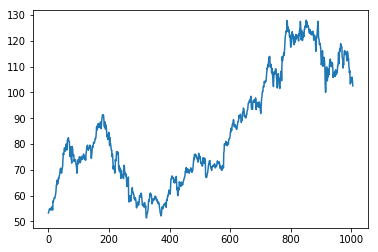

In [48]:
# Uncomment below to use price change time series
# data = data.ix[:, 'Adj Close'].pct_change().dropna().tolist()

plt.plot(data)
plt.show()

#### Generating data:
##### Input features: history data from i to i + WINDOW
##### Output: the data after FORECAST days: @ (i + WINDOW + FORECAST)th day

In [49]:
WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)
print(len(x_train), len(x_test), len(y_train), len(y_test))

list index out of range
70 30 70 30


##### Construct the Model
###### Layers:
1. Fully-connected layer + Normalization layer + Activation: LeakyReLu
2. Dropout layer
3. Fully-connected layer + Normalization layer + Activation: LeakyReLu
4. Fully-connected layer + Activation: Softmax
###### Optimization type : Nadam

In [66]:
model = Sequential()
model.add(Dense(64, input_dim=30,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

###### Train the model

In [67]:
history = model.fit(X_train, Y_train, 
          epochs = 200, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

Train on 873 samples, validate on 98 samples
Epoch 1/200
873/873 [==============================] - 1s - loss: 76.1975 - acc: 0.5120 - val_loss: 38.3089 - val_acc: 0.5102
Epoch 2/200
873/873 [==============================] - 0s - loss: 68.0938 - acc: 0.5292 - val_loss: 32.8919 - val_acc: 0.5102
Epoch 3/200
873/873 [==============================] - 0s - loss: 60.7792 - acc: 0.4971 - val_loss: 28.3140 - val_acc: 0.5306
Epoch 4/200
873/873 [==============================] - 0s - loss: 53.2398 - acc: 0.5292 - val_loss: 24.6422 - val_acc: 0.5204
Epoch 5/200
873/873 [==============================] - 0s - loss: 47.4643 - acc: 0.5452 - val_loss: 21.7374 - val_acc: 0.5102
Epoch 6/200
873/873 [==============================] - 0s - loss: 42.3346 - acc: 0.5120 - val_loss: 19.3574 - val_acc: 0.5306
Epoch 7/200
873/873 [==============================] - 0s - loss: 38.7324 - acc: 0.5166 - val_loss: 17.4414 - val_acc: 0.5612
Epoch 8/200
873/873 [==============================] - 0s - loss: 35.2505

###### Plot data

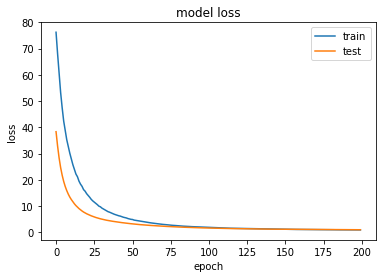

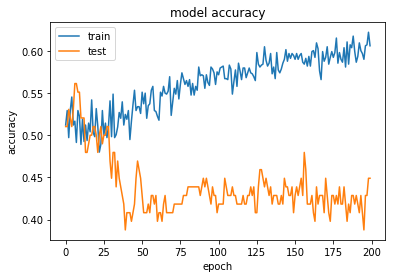

In [68]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

##### The results seem not very good

[[ 0.7173913   0.25      ]
 [ 0.89130435  0.21153846]]


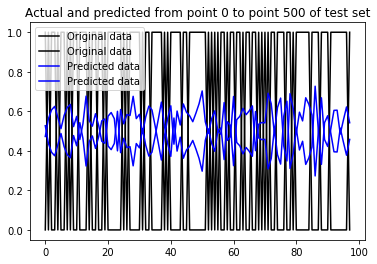

In [70]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(np.array(X_test))
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print(C / C.astype(np.float).sum(axis=1))

FROM = 0
TO = FROM + 500

original = Y_test[FROM:TO]
predicted = pred[FROM:TO] 

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted from point %d to point %d of test set' % (FROM, TO))
plt.show()